In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [10,6]
import datetime
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller

In [3]:
stocks = ['TSLA', '^GSPC', '^DJI', '^IXIC']
start = datetime.datetime(2021, 1, 1)
end = datetime.datetime(2022, 8, 1)
tsla = yf.download(stocks, start=start, end=end, interval='1d')['Close']

[*********************100%%**********************]  4 of 4 completed


In [4]:
tsla.head()

Ticker,TSLA,^DJI,^GSPC,^IXIC
Date,,,,
2021-01-04,243.256668,30223.890625,3700.649902,12698.450195
2021-01-05,245.036667,30391.599609,3726.860107,12818.959961
2021-01-06,251.993332,30829.400391,3748.139893,12740.790039
2021-01-07,272.013336,31041.130859,3803.790039,13067.480469
2021-01-08,293.339996,31097.970703,3824.679932,13201.980469


In [5]:
mdf = tsla.copy()
mdf.corr()

Ticker,TSLA,^DJI,^GSPC,^IXIC
Ticker,,,,
TSLA,1.000000,0.429667,0.612149,0.451557
^DJI,0.429667,1.000000,0.956527,0.820857
^GSPC,0.612149,0.956527,1.000000,0.820034
^IXIC,0.451557,0.820857,0.820034,1.000000


In [12]:
for i in range(len(mdf.columns)):
    adf_test = np.round(adfuller(mdf.iloc[:, i])[1],2)
    print('p-value of {} is {}'.format(mdf.columns[i], adf_test))

p-value of TSLA is 0.26
p-value of ^DJI is 0.12
p-value of ^GSPC is 0.2
p-value of ^IXIC is 0.5


The data is now stationary.

In [13]:
mdf_diff = mdf.diff()
mdf_diff.dropna(inplace=True)

In [15]:
for i in range(len(mdf.columns)):
    adf_test = np.round(adfuller(mdf_diff.iloc[:, i])[1],2)
    print('p-value of {} is {}'.format(mdf.columns[i], adf_test))

p-value of TSLA is 0.0
p-value of ^DJI is 0.0
p-value of ^GSPC is 0.0
p-value of ^IXIC is 0.0


Stationary data.

In [16]:
from statsmodels.tsa.stattools import grangercausalitytests

In [17]:
mdf.columns

Index(['TSLA', '^DJI', '^GSPC', '^IXIC'], dtype='object', name='Ticker')

In [20]:
max_lags = 1
for i in mdf.columns[1:]:
    print(i)
    test_result = grangercausalitytests(mdf_diff[[i, 'TSLA']], maxlag=[max_lags])
    print('--'*50)

^DJI

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3056  , p=0.5807  , df_denom=391, df_num=1
ssr based chi2 test:   chi2=0.3079  , p=0.5790  , df=1
likelihood ratio test: chi2=0.3078  , p=0.5790  , df=1
parameter F test:         F=0.3056  , p=0.5807  , df_denom=391, df_num=1
----------------------------------------------------------------------------------------------------
^GSPC

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0422  , p=0.8374  , df_denom=391, df_num=1
ssr based chi2 test:   chi2=0.0425  , p=0.8366  , df=1
likelihood ratio test: chi2=0.0425  , p=0.8366  , df=1
parameter F test:         F=0.0422  , p=0.8374  , df_denom=391, df_num=1
----------------------------------------------------------------------------------------------------
^IXIC

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2141  , p=0.6439  , df_denom=391, df_num=1
ssr based chi2 test:   chi2=0.2157  , p=0.6423  , df=1
lik

Null Hypothesis H0: Time series X does not Granger cause timeseries y.

H1: Time series X Granger causes timeseries y.

If p-value lower than significance level we reject null hypothesis H0.



Here, since p-value is not less than 0.05, we cannot reject null hypothesis. So we conclude that ^DJI, ^GSPC and ^IXIC are useful for predicting stock price of Tesla.

## VAR - Vector Auto Regression Model

In [21]:
from statsmodels.tsa.api import VAR

In [23]:
train_len = int(len(mdf_diff)*0.8)
train = mdf_diff[:train_len]
test = mdf_diff[train_len:]

In [25]:
var_model = VAR(train)
# to check the optimal no. of lag
res = var_model.select_order(maxlags=30)
print(res.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       28.75*      28.80*  3.051e+12*      28.77*
1        28.77       29.03   3.132e+12       28.88
2        28.84       29.30   3.336e+12       29.02
3        28.89       29.55   3.512e+12       29.15
4        28.97       29.84   3.802e+12       29.31
5        29.00       30.08   3.945e+12       29.43
6        29.05       30.33   4.161e+12       29.57
7        29.10       30.59   4.377e+12       29.70
8        29.16       30.85   4.644e+12       29.84
9        29.21       31.10   4.890e+12       29.97
10       29.26       31.35   5.120e+12       30.10
11       29.26       31.56   5.137e+12       30.18
12       29.30       31.81   5.402e+12       30.31
13       29.38       32.09   5.842e+12       30.47
14       29.39       32.30   5.934e+12       30.56
15       29.41       32.53   6.109e+12       30.66
16       29.43       32.76   6.

### results shows 1 is the optimal lag (since * is the optimal lag and python indexing starts from 0 but actually its 1).

In [28]:
# another way
print(var_model.select_order())

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 0, BIC -> 0, FPE -> 0, HQIC ->  0>


again shows all zeros. thus optimal lag is 1.

In [29]:
results = var_model.fit(1)
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 29, Aug, 2024
Time:                     11:46:14
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    28.9033
Nobs:                     315.000    HQIC:                   28.7603
Log likelihood:          -6282.61    FPE:                2.81248e+12
AIC:                      28.6651    Det(Omega_mle):     2.64078e+12
--------------------------------------------------------------------
Results for equation TSLA
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            0.236236         0.606031            0.390           0.697
L1.TSLA         -0.008984         0.078213           -0.115           0.909
L1.^DJI         -0.004621         0.008233           -0.561           0.575
L1.^G

In [30]:
var_pred = results.forecast(results.endog, steps=len(test))
var_pred = pd.DataFrame(var_pred, columns=mdf_diff.columns + '_pred')
print(var_pred)

Ticker  TSLA_pred  ^DJI_pred  ^GSPC_pred  ^IXIC_pred
0        0.626058 -49.638719   -1.514329    4.946975
1        0.215894  18.240077    2.880530    4.296569
2        0.396570  12.910177    2.493027    4.382127
3        0.375865  13.209245    2.511476    4.365729
4        0.376946  13.214078    2.513928    4.380915
..            ...        ...         ...         ...
74       0.376947  13.215868    2.513913    4.379920
75       0.376947  13.215868    2.513913    4.379920
76       0.376947  13.215868    2.513913    4.379920
77       0.376947  13.215868    2.513913    4.379920
78       0.376947  13.215868    2.513913    4.379920

[79 rows x 4 columns]


In [31]:
test

Ticker,TSLA,^DJI,^GSPC,^IXIC
Date,,,,
2022-04-06,-15.166656,-144.667969,-43.970215,-315.349609
2022-04-07,3.833344,87.058594,19.060059,8.479492
2022-04-08,-10.590027,137.550781,-11.930176,-186.299805
2022-04-11,-16.519989,-413.042969,-75.750000,-299.040039
2022-04-12,3.673340,-87.718750,-15.079590,-40.389648
...,...,...,...,...
2022-07-25,-3.810028,90.750000,5.210205,-51.440430
2022-07-26,-9.573334,-228.500000,-45.790039,-220.099609
2022-07-27,15.960022,436.050781,102.560059,469.849609


In [33]:
var_pred.index = test.index

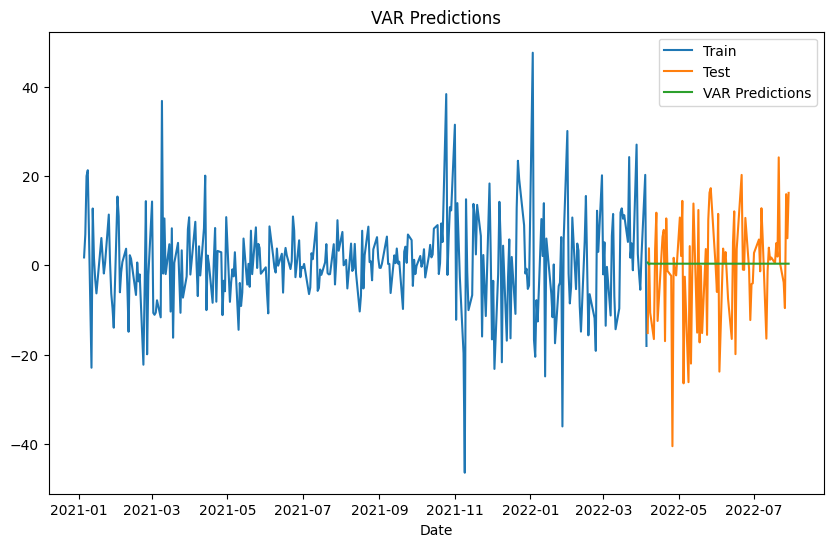

In [34]:
plt.plot(train['TSLA'], label='Train')
plt.plot(test['TSLA'], label='Test')
plt.plot(var_pred['TSLA_pred'], label='VAR Predictions')
plt.title('VAR Predictions')
plt.xlabel('Date')
plt.legend()
plt.show()

since straight line hence not a very good prediction

In [36]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [38]:
mae_var = mean_absolute_error(test['TSLA'], var_pred['TSLA_pred'])
mse_var = mean_squared_error(test['TSLA'], var_pred['TSLA_pred'])
rmse_var = np.sqrt(mean_absolute_error(test['TSLA'], var_pred['TSLA_pred']))

In [39]:
var_perf = {'mae_var': mae_var,
                'mse_var': mse_var,
                'rmse_var': rmse_var}
var_perf = pd.DataFrame([var_perf])
var_perf

,mae_var,mse_var,rmse_var
0,9.115206,147.178341,3.01914


In [40]:
var_model = VAR(mdf_diff)
res = var_model.select_order(maxlags=30)
print(res.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       29.04*      29.08*  4.089e+12*      29.06*
1        29.05       29.26   4.133e+12       29.13
2        29.09       29.47   4.299e+12       29.24
3        29.11       29.67   4.395e+12       29.33
4        29.17       29.90   4.671e+12       29.46
5        29.22       30.12   4.918e+12       29.58
6        29.25       30.32   5.065e+12       29.68
7        29.28       30.52   5.196e+12       29.77
8        29.33       30.74   5.460e+12       29.89
9        29.34       30.92   5.548e+12       29.97
10       29.38       31.13   5.778e+12       30.08
11       29.38       31.30   5.777e+12       30.14
12       29.43       31.53   6.103e+12       30.27
13       29.47       31.74   6.356e+12       30.37
14       29.50       31.93   6.518e+12       30.46
15       29.52       32.12   6.679e+12       30.55
16       29.55       32.33   6.

In [41]:
results = var_model.fit(1)

In [42]:
nsteps = 10
var_forecast = results.forecast(results.endog, steps=nsteps)
var_forecast = pd. DataFrame(var_forecast, columns=mdf_diff.columns + '_forecast')
print(var_forecast)

Ticker  TSLA_forecast  ^DJI_forecast  ^GSPC_forecast  ^IXIC_forecast
0           -0.216932       3.696924       -2.902905      -30.689251
1            0.189844      -5.080992       -0.084135       -3.172154
2            0.118842       6.873980        1.103263       -0.773673
3            0.132155       6.239477        1.017895       -1.146005
4            0.131855       6.130436        1.005061       -1.179636
5            0.131766       6.134569        1.005890       -1.174867
6            0.131764       6.136315        1.006084       -1.174386
7            0.131765       6.136252        1.006072       -1.174448
8            0.131765       6.136229        1.006070       -1.174455
9            0.131765       6.136230        1.006070       -1.174454


In [44]:
forecast_index = pd.date_range(mdf_diff.index[-1],periods=nsteps)
var_forecast.index = forecast_index

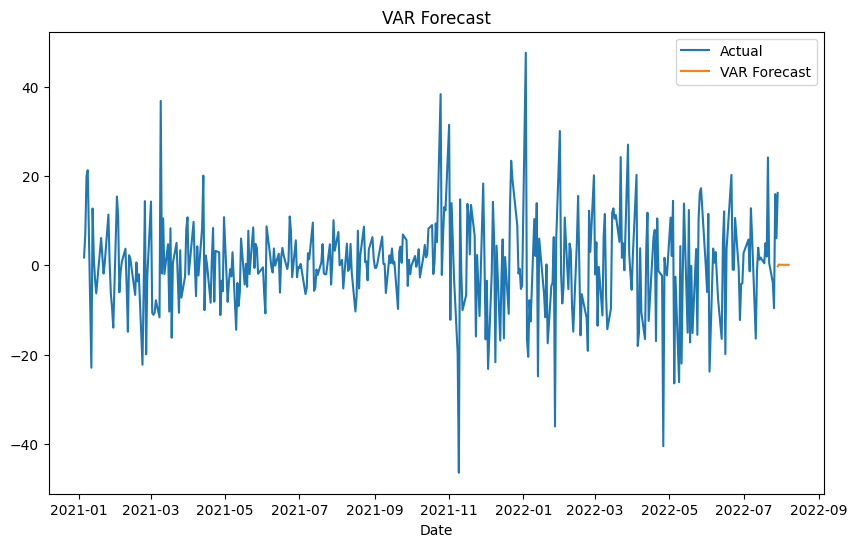

In [45]:
plt.plot(mdf_diff['TSLA'], label='Actual')
plt.plot(var_forecast['TSLA_forecast'], label='VAR Forecast')
plt.title('VAR Forecast')
plt.xlabel('Date')
plt.legend()
plt.show()

Thus we conclude that VAR is not performing well than other time series model. It is more useful than for long term structural analysis.